# The Kavli-ome
> Plotting academic connections for the Kavli Neuroscience Discovery Institute at Johns Hopkins University.

- toc: true
- badges: false
- categories: [pedigo, graspologic, plotting]
- hide: false
- search_exclude: false

 ## Wrangle the data

In [1]:
# collapse
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

from giskard.plot import palplot

years = np.arange(2015, 2022)


savefig_kws = dict(
    dpi=300, pad_inches=0.3, transparent=False, bbox_inches="tight", facecolor="white"
)

layoutplot_kws = dict(node_alpha=0.6, adjust=True)


def stashfig(name, format="png", **kwargs):
    plt.savefig(f"sandbox/results/kavli/{name}.{format}", **savefig_kws)


class MapDict(dict):
    __missing__ = lambda self, key: key


def flatten_muligraph(multigraph, filter_edge_type=None):
    # REF: https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges
    if isinstance(filter_edge_type, str):
        filter_edge_type = [filter_edge_type]
    g = nx.Graph()
    # for node in multigraph.nodes():
    #     g.add_node(node)
    for i, j, data in multigraph.edges(data=True):
        edge_type = data["type"]
        if filter_edge_type is None or edge_type in filter_edge_type:
            w = data["weight"] if "weight" in data else 1.0
            if g.has_edge(i, j):
                g[i][j]["weight"] += w
            else:
                g.add_edge(i, j, weight=w)
    return g


# load the data
data_loc = "sandbox/data/kavli/Kavli Interconnections 2021.xlsx"
data = pd.read_excel(data_loc)
data["source"] = list(data["source_first"] + " " + data["source_last"])
data["target"] = list(data["target_first"] + " " + data["target_last"])

# ignore anything having to do with "joined" for the purposes of the edgelist
edges = data[data["type"] != "joined"].copy()
# these are edges that are not edges?
bad_edges = edges[edges["source"].isna() | edges["target"].isna()]
print("Ignoring bad edges:")
print()
bad_edges

/Users/bpedigo/miniconda3/envs/sandbox/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
Ignoring bad edges:



,source_first,source_last,target_first,target_last,ternal,target_dept,start,end,type,Unnamed: 9,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,source,target
5,Andreas,Andreou,NaN,NaN,External,"Cornelia Fermuller, Shihab Shamma, Behtash Bab...",2021.0,2026,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andreas Andreou,NaN
6,Andreas,Andreou,NaN,NaN,External,Northrop Grumman,2021.0,2025,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andreas Andreou,NaN
42,Seth,Blackshaw,NaN,NaN,NaN,Neuroscience,2020.0,2025,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seth Blackshaw,NaN
43,Seth,Blackshaw,NaN,NaN,NaN,Neuroscience,2020.0,2022,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seth Blackshaw,NaN
44,Seth,Blackshaw,NaN,NaN,NaN,Neuroscience,2021.0,2026,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seth Blackshaw,NaN
83,Brian,Caffo,NaN,NaN,NaN,Biostat,2020.0,2023,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brian Caffo,NaN
123,Brian,Caffo,NaN,NaN,NaN,Biostat,NaN,2016,Publication,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brian Caffo,NaN
125,Vikram,Chib,NaN,NaN,NaN,Neuroscience,2019.0,2023,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vikram Chib,NaN
126,Vikram,Chib,NaN,NaN,NaN,Neuroscience,2019.0,2024,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vikram Chib,NaN
302,James,Knierim,NaN,NaN,NaN,Neuroscience,2018.0,Ongoing,Funded Grant,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,James Knierim,NaN


In [2]:
# collapse
edges = edges[~edges.index.isin(bad_edges.index)]

mg = nx.from_pandas_edgelist(
    edges, edge_attr=["type", "ternal", "start", "end"], create_using=nx.MultiGraph
)
g = flatten_muligraph(mg)

# some node metadata
targets = edges["target"].unique()
sources = edges["source"].unique()
node_ids = np.unique(np.array(list(targets) + list(sources)))
nodes = pd.DataFrame(index=node_ids)
departments = edges.groupby("target")["target_dept"].agg(lambda x: x.mode()[0])
nodes["dept"] = nodes.index.map(departments).fillna("unk")

edge_types = edges["type"].unique()
joined = data[data["type"] == "joined"].set_index("source")
nodes["core"] = False
nodes.loc[nodes.index.isin(joined.index), "core"] = True

# mapping departments
dept_map = {
    "BME/JHM": "BME",
    "Mind Brain Institute": "MBI",
    "Mind Brain Institute, Neuroscience": "Neuroscience",
    "BME/Ophthalmology": "BME",
    "Neuro": "Neuroscience",
    "Neuro + BME": "Neuroscience",
    "Biostat": "Biostats",
    "ME": "Mechanical Engineering",
}

dept_map = MapDict(dept_map)

nodes["dept"] = nodes["dept"].map(dept_map)
nodes.loc["Peter Searson", "dept"] = "Materials Science and Engineering"



 ## Create a color palette by department/institute

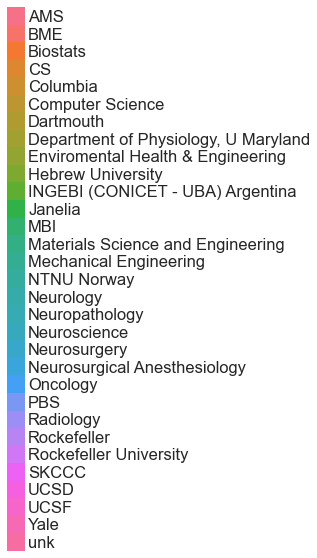

In [3]:
# collapse
colors = sns.color_palette("husl", nodes["dept"].nunique())
palette = dict(zip(sorted(nodes["dept"].unique()), colors))
nodes["color"] = nodes["dept"].map(palette)
sns.set_context("talk")
palplot(palette)
stashfig("palette")


 ## Plot the complete network

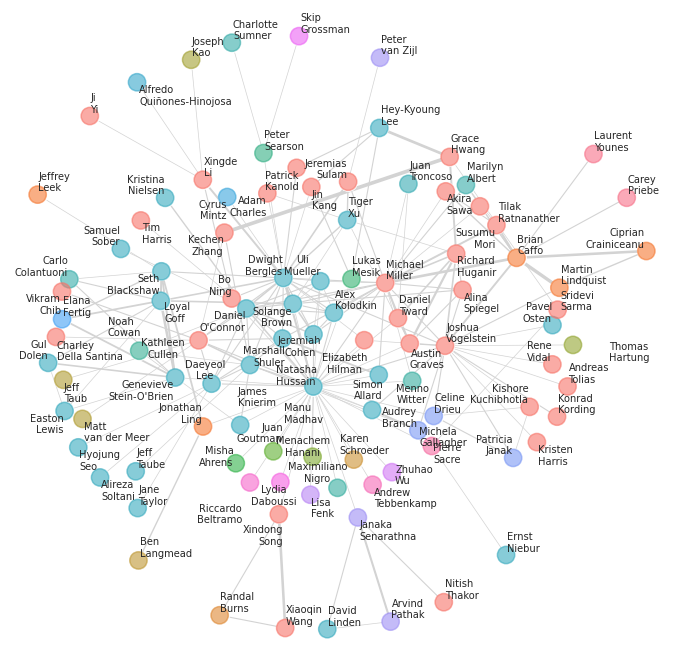

In [4]:
# collapse


def layoutplot(
    g,
    pos,
    nodes,
    ax=None,
    figsize=(10, 10),
    weight_scale=1,
    adjust=True,
    log_weights=True,
    node_alpha=1,
    label_nodes=True,
    node_size=300,
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    edgelist = g.edges()
    weights = np.array([g[u][v]["weight"] for u, v in edgelist])
    # weight transformations happen here, can be important
    if log_weights:
        weights = np.log(weights + 1)
    weights *= weight_scale

    # plot the actual layout
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=nodes.index,
        node_color="white",
        zorder=-1,
        node_size=node_size,
        ax=ax,
    )
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=nodes.index,
        node_color=nodes["color"],
        alpha=node_alpha,
        node_size=node_size,
        ax=ax,
    )
    nx.draw_networkx_edges(
        g,
        pos,
        edgelist=edgelist,
        nodelist=nodes.index,
        width=weights,
        zorder=-2,
        edge_color="lightgrey",
        alpha=1,
        ax=ax,
        node_size=node_size,  # connectionstyle="arc3,rad=0.2"
    )
    if label_nodes:
        texts = []
        for node in nodes.index:
            node_pos = pos[node]
            split = node.split(" ")
            name = split[0] + "\n"
            name += node[len(split[0]) + 1 :]
            text = ax.text(
                node_pos[0],
                node_pos[1],
                name,
                ha="center",
                va="center",
                fontname="DejaVu Sans",
            )
            # text.set_bbox(dict(facecolor="white", alpha=0.3, edgecolor="white"))
            texts.append(text)
        if adjust:
            adjust_text(texts, expand_text=(1, 1), lim=100, avoid_self=False)

    ax.axis("off")

    return ax


sns.set_context("talk", font_scale=0.55)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pos = nx.kamada_kawai_layout(g, weight=None)
layoutplot(g, pos, nodes, ax=ax, **layoutplot_kws)
stashfig("kavli-all")



 ## Plot the core Kavli group by year

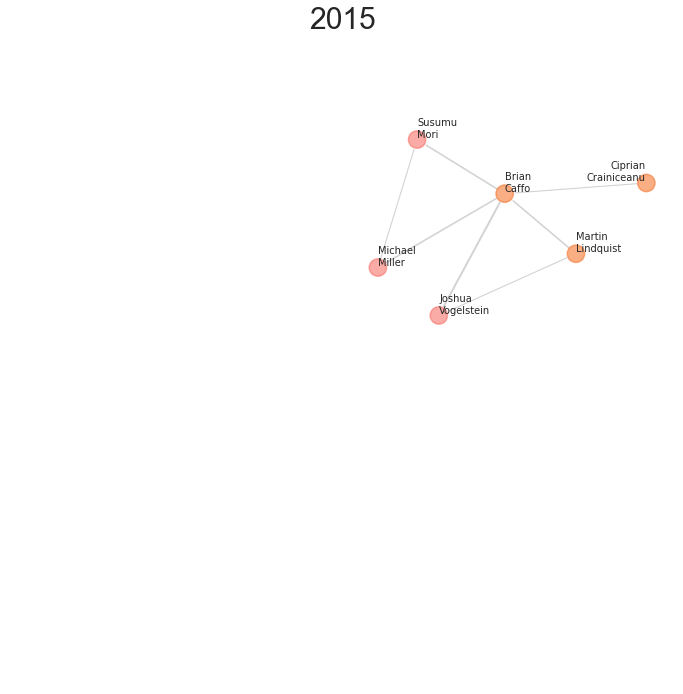

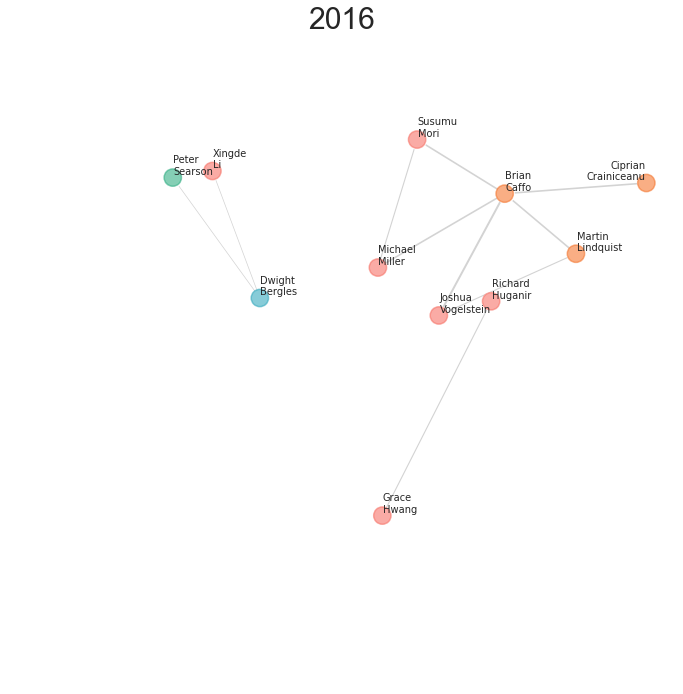

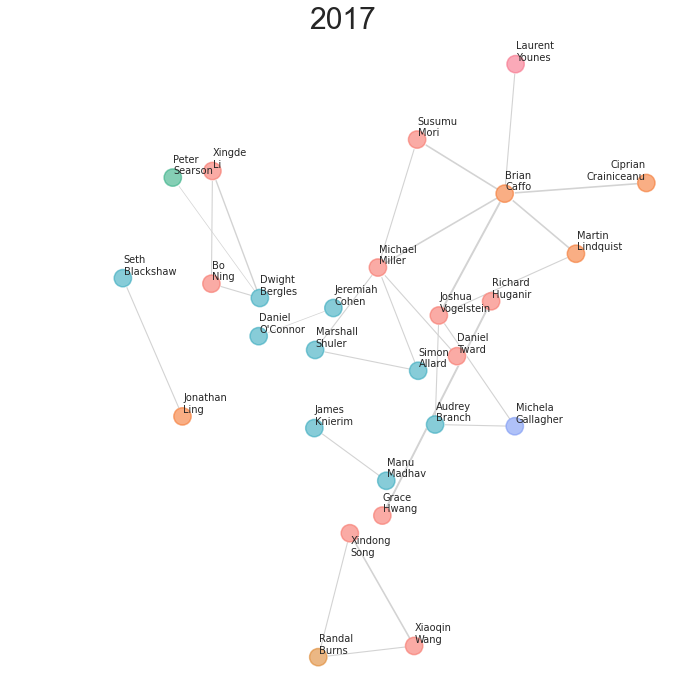

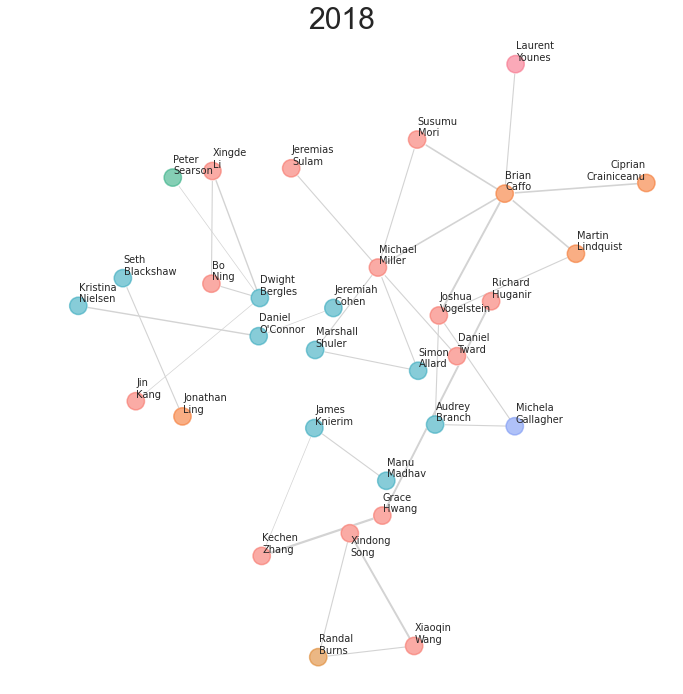

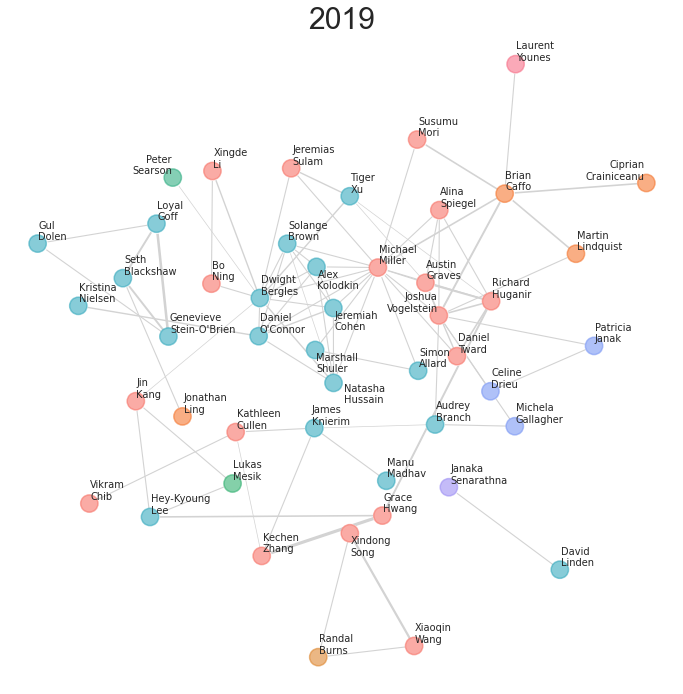

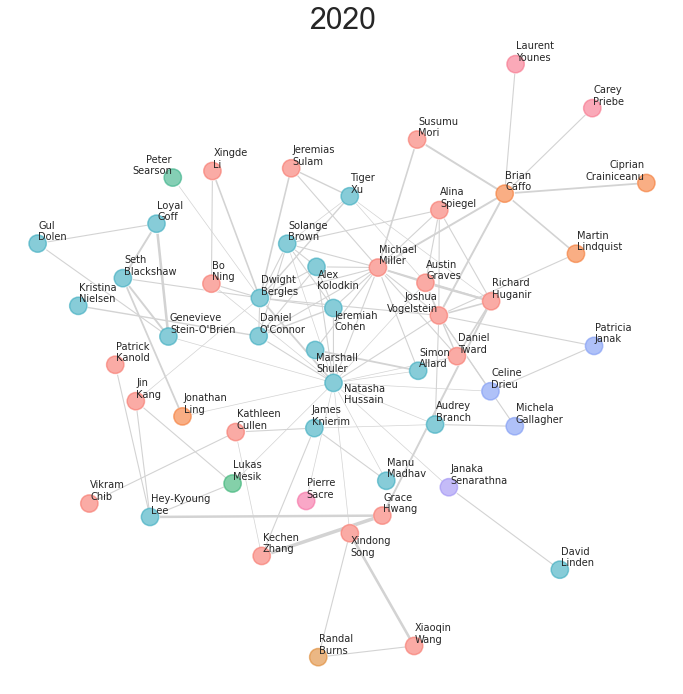

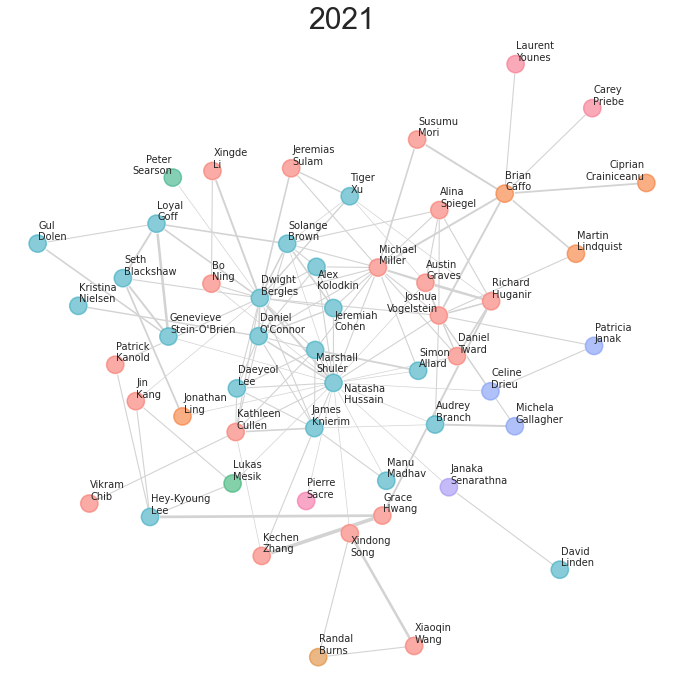

In [5]:
# collapse
def calculate_bounds(pos, pad=0.05):
    xy = np.stack(list(pos.values()), axis=1).T
    xmin = xy[:, 0].min()
    xmax = xy[:, 0].max()
    ymin = xy[:, 1].min()
    ymax = xy[:, 1].max()
    xpad = (xmax - xmin) * pad
    ypad = (ymax - ymin) * pad
    xlim = (xmin - xpad, xmax + xpad)
    ylim = (ymin - ypad, ymax + ypad)
    return xlim, ylim


def extract_year_mgs(mg):
    year_mgs = {}
    for year in years:
        select_edges = []
        for (u, v, k, d) in mg.edges(data=True, keys=True):
            edge_year = d["start"]
            if edge_year <= year:
                select_edges.append((u, v, k))
        year_mg = nx.edge_subgraph(mg, select_edges)
        year_mgs[year] = year_mg
    return year_mgs


core_mg = nx.subgraph(mg, nodes[nodes["core"]].index)
core_flat_g = flatten_muligraph(core_mg)
core_pos = nx.kamada_kawai_layout(core_flat_g, weight=None)
xlim, ylim = calculate_bounds(core_pos)

year_mgs = extract_year_mgs(core_mg)

for year in years:
    year_mg = year_mgs[year]
    year_g = flatten_muligraph(year_mg)
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    layoutplot(
        year_g, core_pos, nodes[nodes.index.isin(year_g.nodes)], ax=ax, **layoutplot_kws
    )
    ax.set_title(year, fontsize=30)
    ax.set(xlim=xlim, ylim=ylim)
    stashfig(f"kavli-core-year-{year}")

 ## Plot the entire network by year

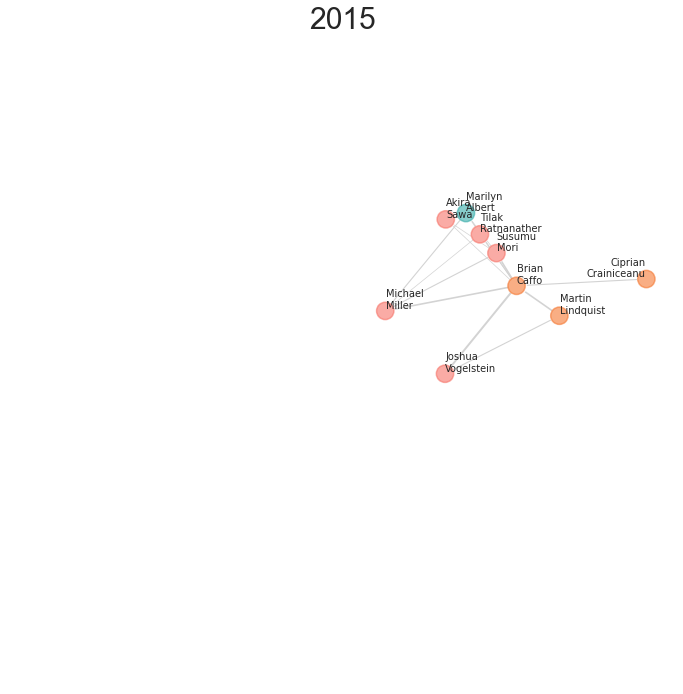

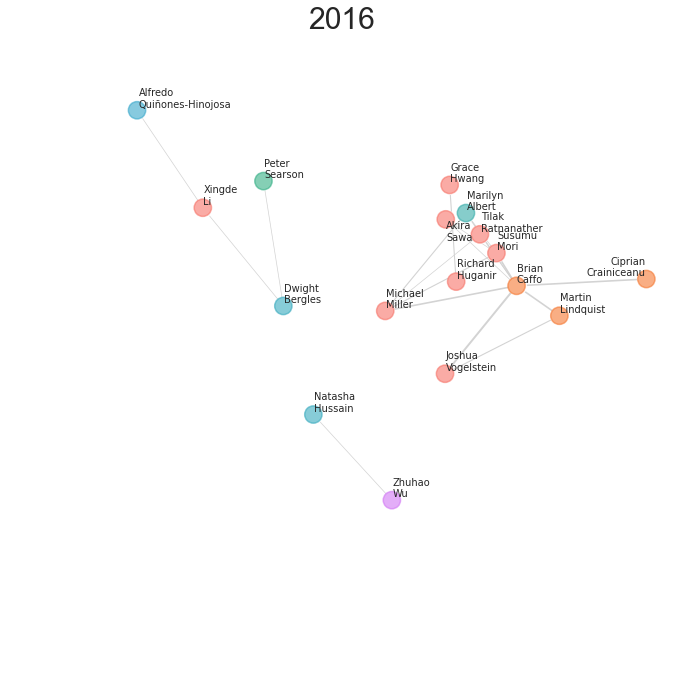

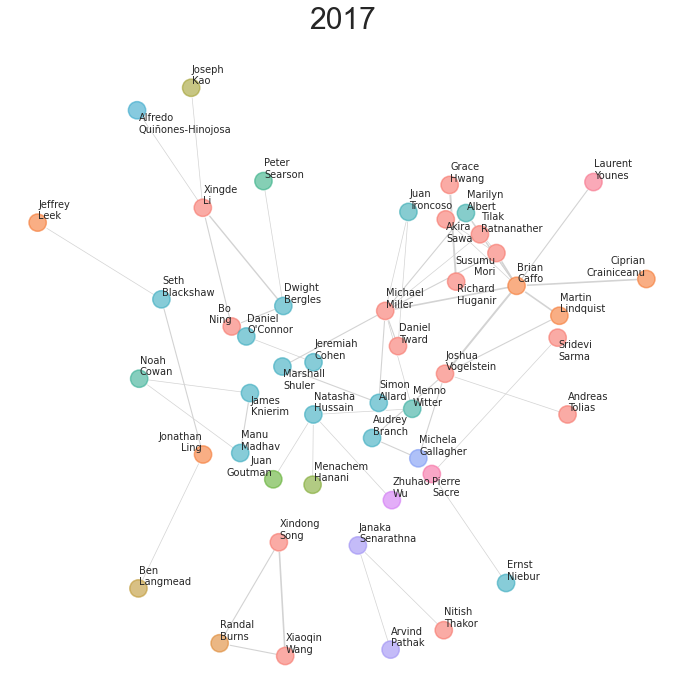

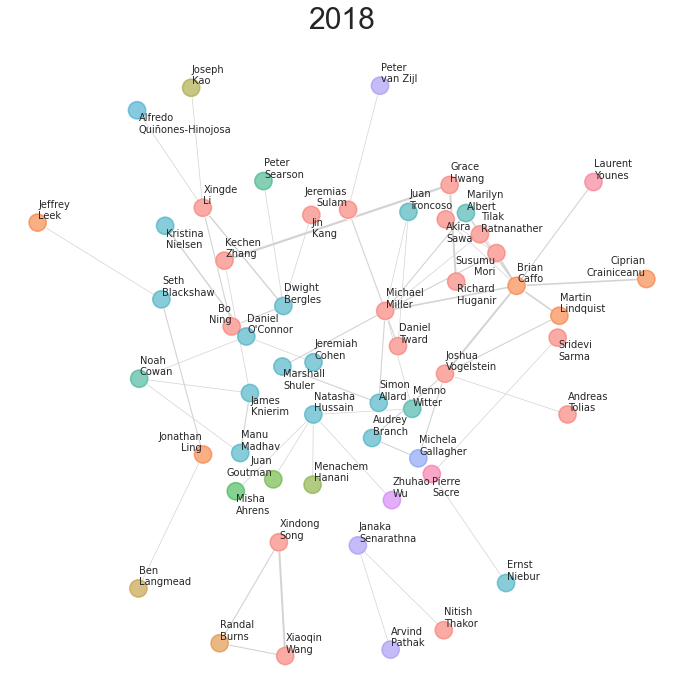

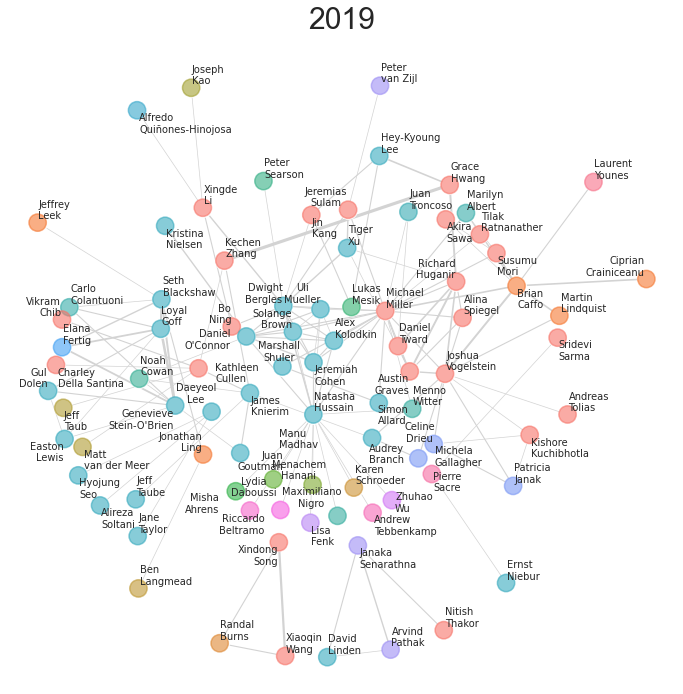

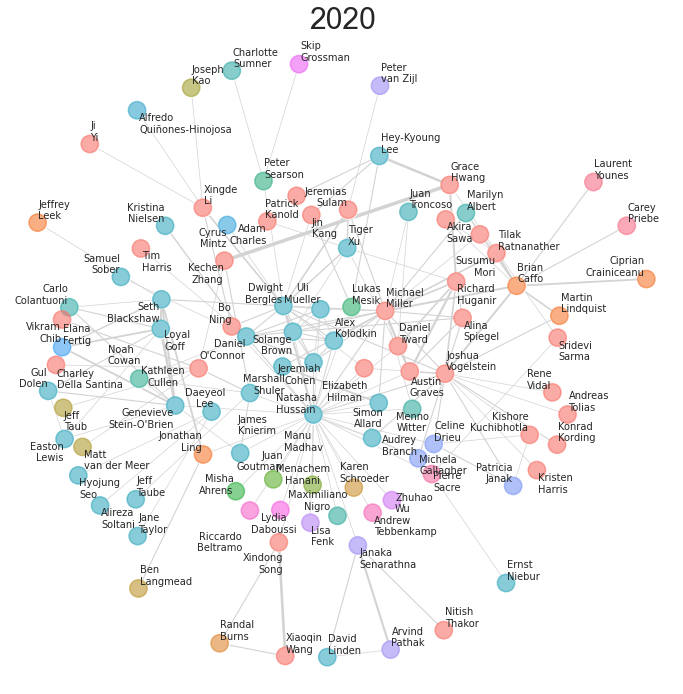

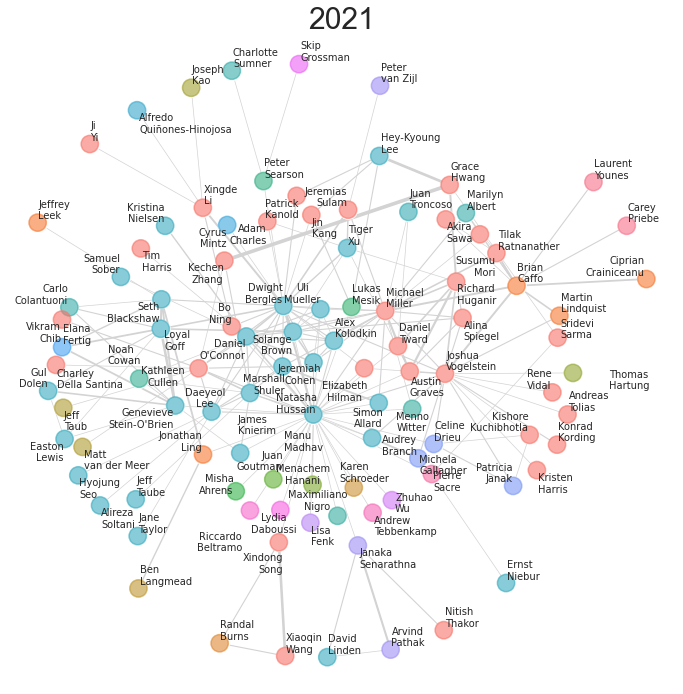

In [6]:
# collapse
flat_g = flatten_muligraph(mg)
pos = nx.kamada_kawai_layout(flat_g, weight=None)
xlim, ylim = calculate_bounds(pos)
year_mgs = extract_year_mgs(mg)
for year in years:
    year_mg = year_mgs[year]
    year_g = flatten_muligraph(year_mg)
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    layoutplot(
        year_g, pos, nodes[nodes.index.isin(year_g.nodes)], ax=ax, **layoutplot_kws
    )
    ax.set_title(year, fontsize=30)
    ax.set(xlim=xlim, ylim=ylim)
    stashfig(f"kavli-all-year-{year}")


 ## Plot each type of connection separately

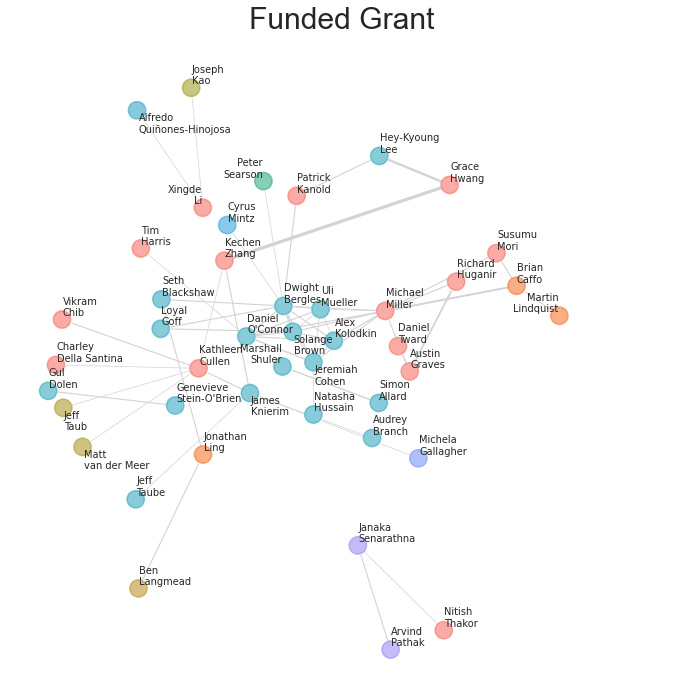

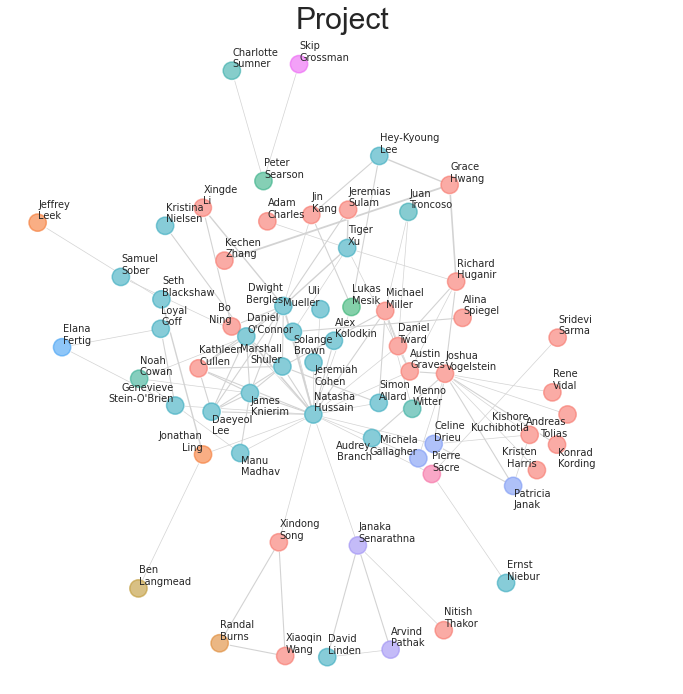

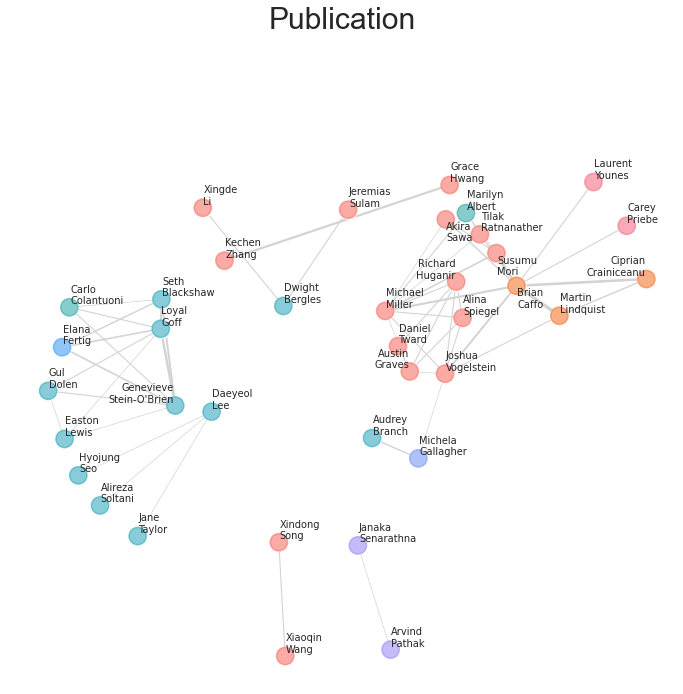

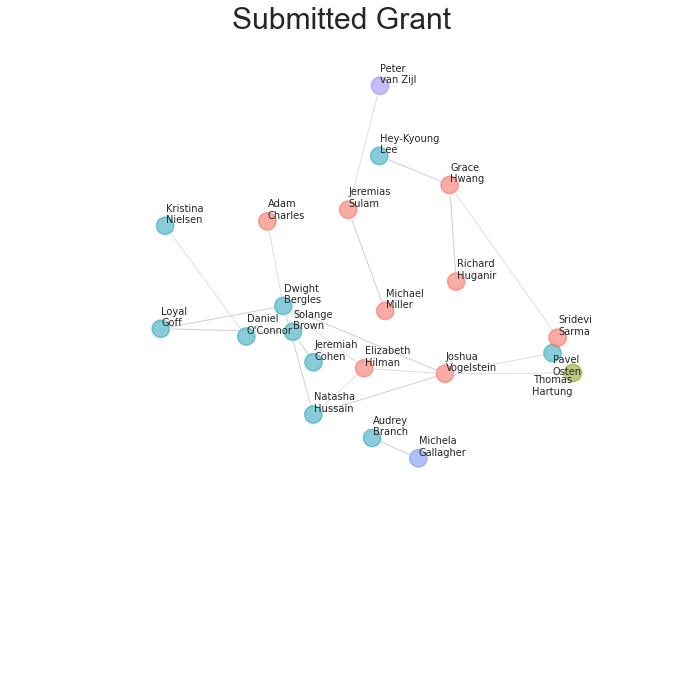

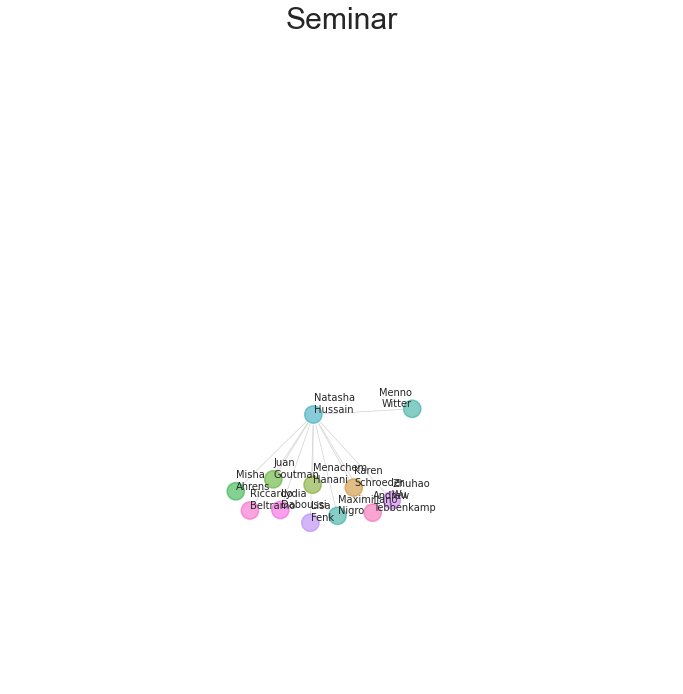

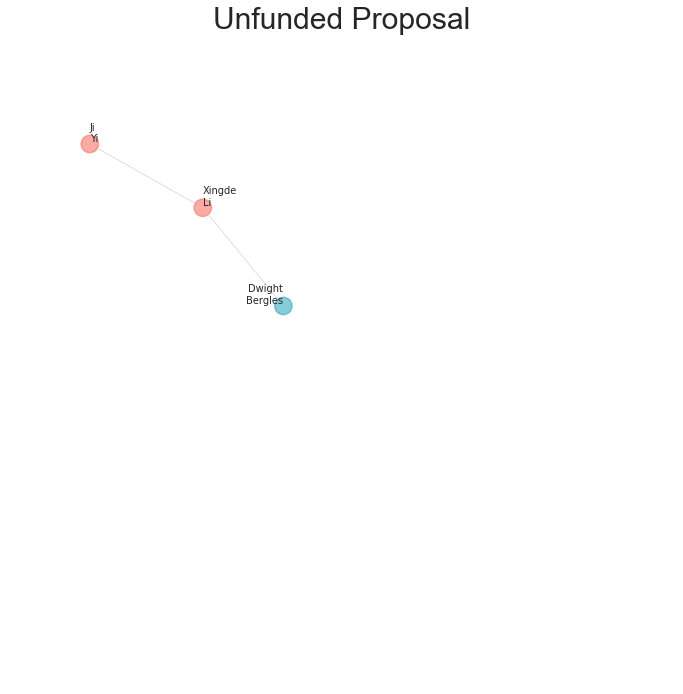

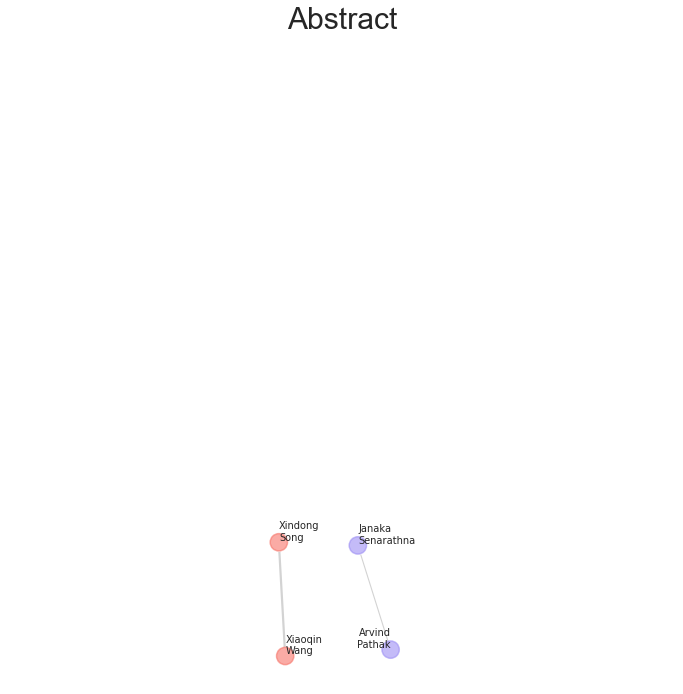

In [7]:
# collapse
for edge_type in edge_types:
    edge_type_g = flatten_muligraph(mg, filter_edge_type=edge_type)
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    layoutplot(
        edge_type_g,
        pos,
        nodes[nodes.index.isin(edge_type_g.nodes)],
        ax=ax,
        **layoutplot_kws,
    )
    ax.set_title(edge_type, fontsize=30)
    ax.set(xlim=xlim, ylim=ylim)
    stashfig(f"kavli-all-edge-type-{edge_type}")


 ## Plot each type of connection on the same set of axes

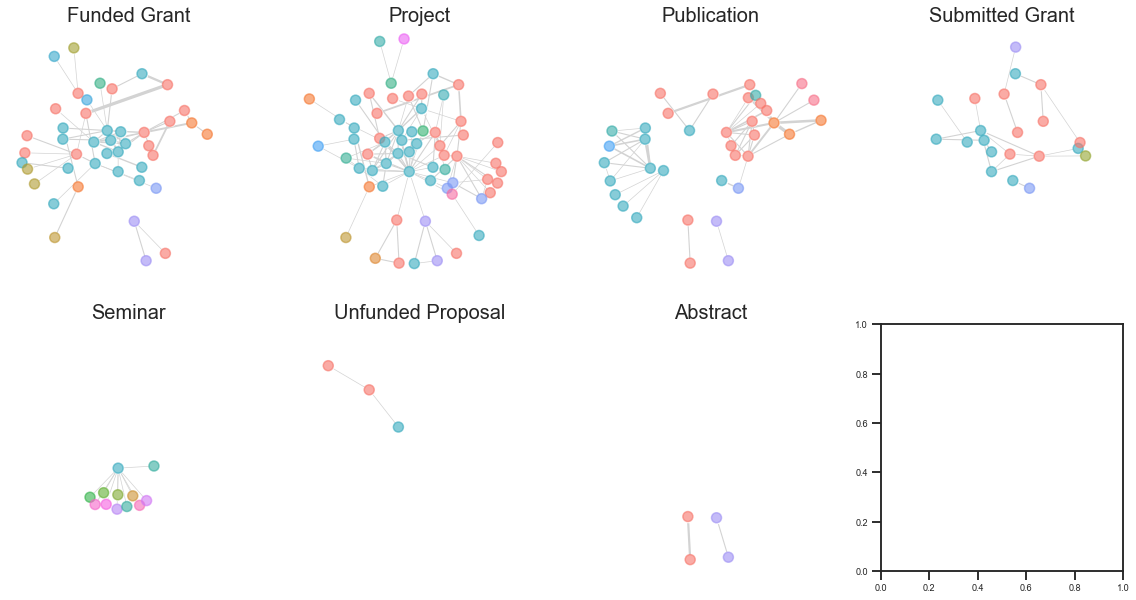

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, edge_type in enumerate(edge_types):
    ax = axs.flat[i]
    edge_type_g = flatten_muligraph(mg, filter_edge_type=edge_type)
    layoutplot(
        edge_type_g,
        pos,
        nodes[nodes.index.isin(edge_type_g.nodes)],
        ax=ax,
        node_size=100,
        label_nodes=False,
        **layoutplot_kws,
    )
    ax.set_title(edge_type, fontsize=20)
    ax.set(xlim=xlim, ylim=ylim)
stashfig(f"kavli-all-edge-types")
